In [7]:
import keras
from keras.layers import Dense, BatchNormalization, Dropout, GlobalAveragePooling2D, Flatten, Conv2D, MaxPooling2D
from keras.preprocessing import image
from keras.regularizers import l2
from sklearn.model_selection import train_test_split
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import re

In [2]:
datagen = image.ImageDataGenerator(
    rescale = 1./255,
    zoom_range=0.2,
    fill_mode='reflect',
    rotation_range=20,
    horizontal_flip=True
    )

#datagen.fit(X_train)

In [3]:
image_dir = "skin-images"
data_df = pd.read_csv('skin_condition_label1.csv')

In [4]:
# Parameters
BATCH_SIZE = 32
TARGET_SIZE = (224, 224)
INPUT_SHAPE= (224, 224, 3)

train_df, test_df = train_test_split(data_df, random_state = 80, test_size=0.2)

train_generator = datagen.flow_from_dataframe(
    train_df,
    directory = image_dir,
    x_col = "file_id",
    y_col = ["1_texture","1_pores","1_spot","1_saggy","1_clear","1_melanin","1_wrinkles"],
    target_size = TARGET_SIZE,
    batch_size = BATCH_SIZE,
    class_mode = "raw"
)

test_generator = datagen.flow_from_dataframe(
    test_df,
    directory = image_dir,
    x_col = "file_id",
    y_col = ["1_texture","1_pores","1_spot","1_saggy","1_clear","1_melanin","1_wrinkles"],
    target_size = TARGET_SIZE,
    batch_size = BATCH_SIZE,
    class_mode = "raw"
)

Found 1316 validated image filenames.
Found 330 validated image filenames.


[3 3 3 3 3 3 3]


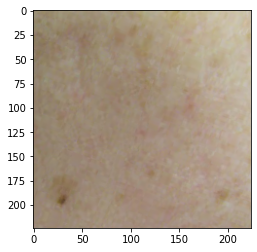

In [5]:
plt.imshow(test_generator[4][0][31])
print(test_generator[4][1][31])

In [8]:
densenet = tf.keras.applications.DenseNet169(
    include_top = False, 
    weights = "imagenet",
    input_shape = INPUT_SHAPE
    )

# Unfreeze the last conv block
set_trainable = False
densenet.Trainable = True
for layer in densenet.layers:
    if re.match("^conv5_block*", layer.name) is not None:
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

x = GlobalAveragePooling2D()(densenet.output)
x = Dense(units = 256, activation = 'relu')(x)
x = Dropout(0.4)(x)
x = BatchNormalization()(x)
x = Dense(units = 128, activation = 'relu')(x)
x = Dropout(0.1)(x)
x = Dense(units = 64, activation = 'relu')(x)
pred = Dense(units = 7, activation = 'softmax', kernel_regularizer = l2(l = 0.01))(x)
model = keras.models.Model(inputs = densenet.input, outputs = pred)
model.load_weights('./tmp/finalresult/densenet_skin_finetuned_best.h5')

In [9]:
x = model.layers[-8].output
x = Dense(256, activation='relu')(x)
x = BatchNormalization()(x)
x = Dense(128, activation='relu')(x)
x = BatchNormalization()(x)
x = Dense(64, activation='relu')(x)
x = Dense(32, activation='relu')(x)
output = Dense(7, activation='relu')(x)
model = keras.models.Model(inputs = model.input, outputs = output)
model.load_weights('./tmp/finalresult/transfer_best_1.h5')

In [10]:
#newmodel.summary()

In [11]:
model.compile(optimizer='adam', loss='mse', metrics=['mae','accuracy'])

In [12]:
checkpoint_filepath = './tmp/checkpoint(transferred_finetuning)/cp-{epoch:04d}.h5'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_acc',
    period=1,
    mode='auto',
    save_best_only=False)

In [13]:
# Fit model
history = model.fit(
    train_generator,
    epochs = 30,
    validation_data = test_generator,
    callbacks=[model_checkpoint_callback]
  )

Epoch 1/30
42/42 [==============================] - 17s 409ms/step - loss: 0.4502 - mae: 0.5321 - accuracy: 0.6163 - val_loss: 1.3275 - val_mae: 0.8653 - val_accuracy: 0.4121
Epoch 2/30
42/42 [==============================] - 14s 328ms/step - loss: 0.4267 - mae: 0.5166 - accuracy: 0.6581 - val_loss: 0.9639 - val_mae: 0.7029 - val_accuracy: 0.4303
Epoch 3/30
42/42 [==============================] - 14s 328ms/step - loss: 0.4156 - mae: 0.5115 - accuracy: 0.6611 - val_loss: 0.5139 - val_mae: 0.5575 - val_accuracy: 0.6485
Epoch 4/30
42/42 [==============================] - 14s 325ms/step - loss: 0.4115 - mae: 0.5080 - accuracy: 0.6117 - val_loss: 0.6273 - val_mae: 0.5697 - val_accuracy: 0.5485
Epoch 5/30
42/42 [==============================] - 14s 327ms/step - loss: 0.4058 - mae: 0.5032 - accuracy: 0.6033 - val_loss: 0.4671 - val_mae: 0.5357 - val_accuracy: 0.6394
Epoch 6/30
42/42 [==============================] - 14s 326ms/step - loss: 0.4013 - mae: 0.4990 - accuracy: 0.6398 - val_loss

In [14]:
acc      = history.history['accuracy']
val_acc  = history.history['val_accuracy']
loss     = history.history['loss']
val_loss = history.history['val_loss']
mae     = history.history['mae']
val_mae = history.history['val_mae']

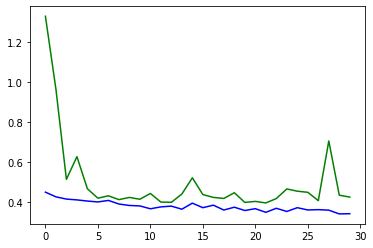

In [15]:
epochs = range(len(loss))
plt.plot(epochs,loss,"b",label="Training loss")
plt.plot(epochs,val_loss,"g",label="validation loss")

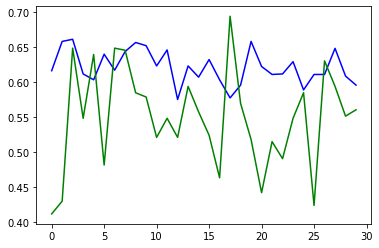

In [16]:
plt.plot(epochs,acc,"b",label="Training accuracy")
plt.plot(epochs,val_acc,"g",label="validation accuracy")

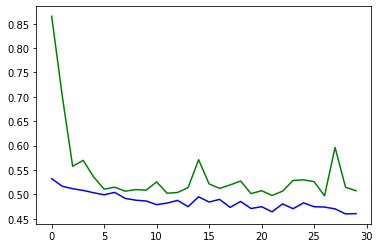

In [17]:
plt.plot(epochs,mae,"b",label="Training accuracy")
plt.plot(epochs,val_mae,"g",label="validation accuracy")